In [1]:
import gym
import sys
import itertools
import matplotlib
import numpy as np
import pandas as pd
from collections import defaultdict, namedtuple

from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler as Scaler
from sklearn.linear_model import SGDRegressor as SGD
from sklearn.kernel_approximation import RBFSampler as RBF

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline
matplotlib.style.use('ggplot')

In [2]:
env = gym.envs.make("MountainCar-v0")

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [7]:
class Estimator():
    """
    Value Function approximator. 
    """
    def __init__(self):        
        # sampleing envrionment state in order to featurize it. 
        observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        
        # Feature Preprocessing: Normalize to zero mean and unit variance
        # We use a few samples from the observation space to do this
        self.scaler = Scaler()
        self.scaler.fit(observation_examples)
                
        # Used to convert a state to a featurizes represenation.
        # We use RBF kernels with different variances to cover different parts of the space
        self.featurizer = FeatureUnion([
                ("rbf1", RBF(gamma=5.0, n_components=100)),
                ("rbf2", RBF(gamma=2.0, n_components=100)),
                ("rbf3", RBF(gamma=1.0, n_components=100)),
                ("rbf4", RBF(gamma=0.5, n_components=100))
                ])
        self.featurizer.fit(self.scaler.transform(observation_examples))

        # action model for SGD regressor
        self.action_models = []
        self.nA = env.action_space.n
        
        for na in range(self.nA):
            model = SGD(learning_rate="constant")
            model.partial_fit([self.__featurize_state(env.reset())], [0])
            self.action_models.append(model)
    
        # print(self.action_models)
        
    def __featurize_state(self, state):
        """
        Returns the featurized representation for a state.
        """
        scaled = self.scaler.transform([state])
        return self.featurizer.transform(scaled)[0]
    
    def predict(self, s, a=None):
        """
        Makes value function predictions.
        
        Args:
            s: state to make a prediction for
            a: (Optional) action to make a prediction for
            
        Returns
            If an action a is given this returns a single number as the prediction.
            If no action is given this returns a vector or predictions for all actions
            in the environment where pred[i] is the prediction for action i.
            
        """
        features = self.__featurize_state(s)
        if not a:
            return np.array([model.predict([features])[0] for model in self.action_models])
        else:
            return self.action_models[a].predict([features])[0]
    
    def update(self, s, a, y):
        """
        Updates the estimator parameters for a given state and action towards
        the target y.
        """
        cur_features = self.__featurize_state(s)
        self.action_models[a].partial_fit([cur_features], [y])

In [9]:
class VF_QLearning():
    """
    Value Funciton Approximator with Q-learning 
    
    Q-Learning algorithm for TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.
    """
    def __init__(self, env, estimator, 
                 num_episodes, epsilon=0.1, 
                 discount_factor=1.0, epsilon_decay=1.0):
        
        self.nA = env.action_space.n
        self.nS = env.observation_space.shape[0]
        self.env = env
        self.num_episodes = num_episodes
        self.epsilon = epsilon
        self.discount_factor = discount_factor
        self.epsilon_decay = epsilon_decay
        self.estimator = estimator
        
        # Keeps track of useful statistics
        record_head = namedtuple("Stats",["episode_lengths", "episode_rewards"])
        self.record = record_head(
            episode_lengths=np.zeros(num_episodes),
            episode_rewards=np.zeros(num_episodes))
        
    def __epislon_greedy_policy(self, nA, epislon=0.5):
        """
        epislon greedy policy algorithm
        """
        def policy(state):
            A = np.ones(nA, dtype=float) * epislon / nA
            Q = self.estimator.predict(state)
            best_action = np.argmax(Q)
            A[best_action] += (1.0 - epislon)
            
            return A
        
        return policy
            
    def __random_aciton(self, action_prob):
        """
        """
        return np.random.choice(np.arange(len(action_prob)), p=action_prob)
    
    def q_learning(self):
        """
        """
        for i_episode in range(self.num_episodes):
            # print the number iter episode
            num_present = (i_episode+1)/self.num_episodes
            print("Episode {}/{}".format(i_episode + 1, self.num_episodes), end="")
            print("="*round(num_present*60))
            
            # The policy we're following
            policy_epislon = self.epsilon * self.epsilon_decay**i_episode
            policy = self.__epislon_greedy_policy(self.nA, policy_epislon)

            # Print out which episode we're on, useful for debugging.
            # Also print reward for last episode
            last_reward = self.record.episode_rewards[i_episode - 1]
            sys.stdout.flush()

            # Reset the environment and pick the first action
            state = env.reset()

            next_action = None
            
            # One step in the environment, replace while(True)
            for t in itertools.count():
                action_probs = policy(state)
                action = self.__random_aciton(action_probs)
                
                # Take a step
                next_state, reward, done, _ = env.step(action)

                # Update statistics
                self.record.episode_rewards[i_episode] += reward
                self.record.episode_lengths[i_episode] = t

                # TD Update
                q_values_next = estimator.predict(next_state)
                # Q-Value TD Target
                td_target = reward + self.discount_factor * np.max(q_values_next)
                # Update the function approximator using our target
                estimator.update(state, action, td_target)

                print("\rStep {} with reward ({})".format(t, last_reward), end="")

                if done: break

                state = next_state

        return self.record

In [32]:
estimator = Estimator()
vf = VF_QLearning(env, estimator, num_episodes=100, epsilon=0.2)
result = vf.q_learning()

Episode 1/100=


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDRegressor'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Step 199 with reward (0.0)Episode 2/100=
Step 199 with reward (-200.0)Episode 3/100==
Step 199 with reward (-200.0)Episode 4/100==
Step 199 with reward (-200.0)Episode 5/100===
Step 199 with reward (-200.0)Episode 6/100====
Step 199 with reward (-200.0)Episode 7/100====
Step 199 with reward (-200.0)Episode 8/100=====
Step 199 with reward (-200.0)Episode 9/100=====
Step 199 with reward (-200.0)Episode 10/100======
Step 199 with reward (-200.0)Episode 11/100=======
Step 199 with reward (-200.0)Episode 12/100=======
Step 199 with reward (-200.0)Episode 13/100========
Step 199 with reward (-200.0)Episode 14/100========
Step 199 with reward (-200.0)Episode 15/100=========
Step 199 with reward (-200.0)Episode 16/100==========
Step 199 with reward (-200.0)Episode 17/100==========
Step 199 with reward (-200.0)Episode 18/100===========
Step 199 with reward (-200.0)Episode 19/100===========
Step 199 with reward (-200.0)Episode 20/100============
Step 199 with reward (-200.0)Episode 21/100=======

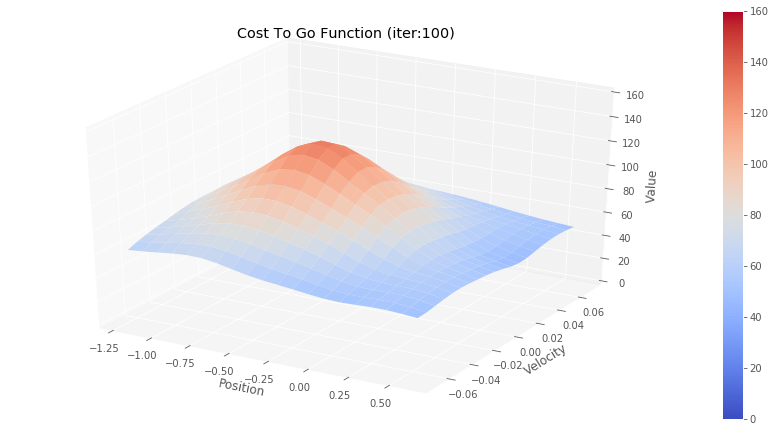

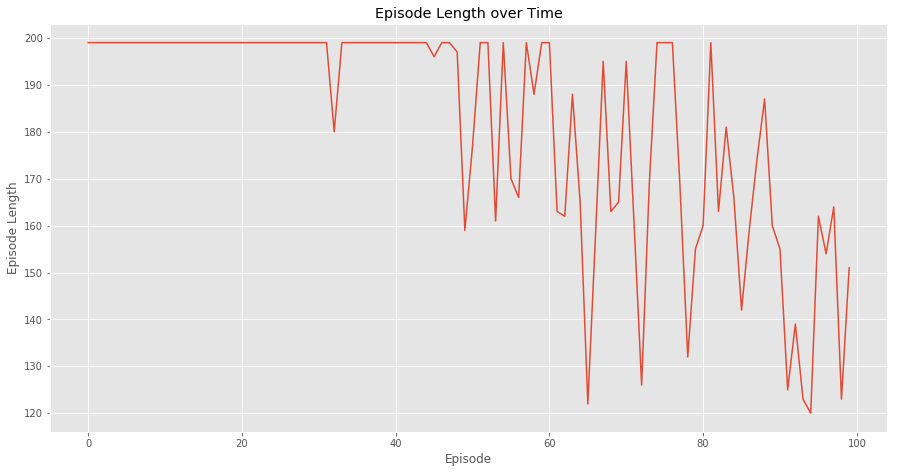

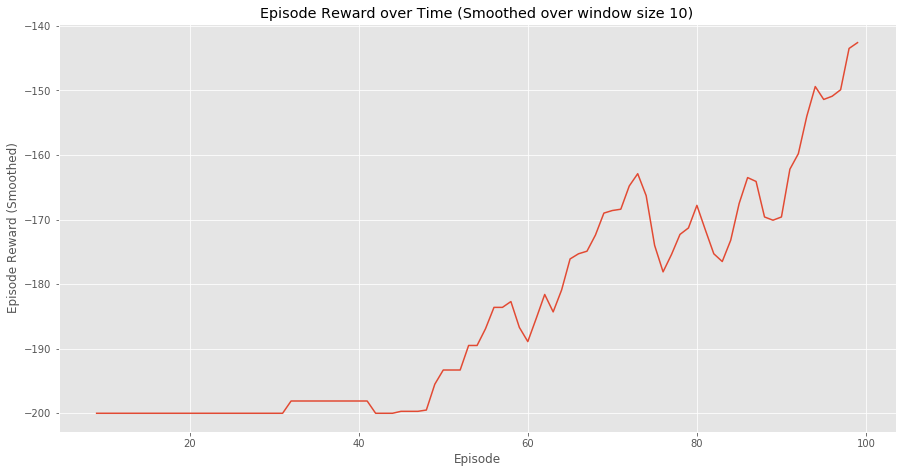

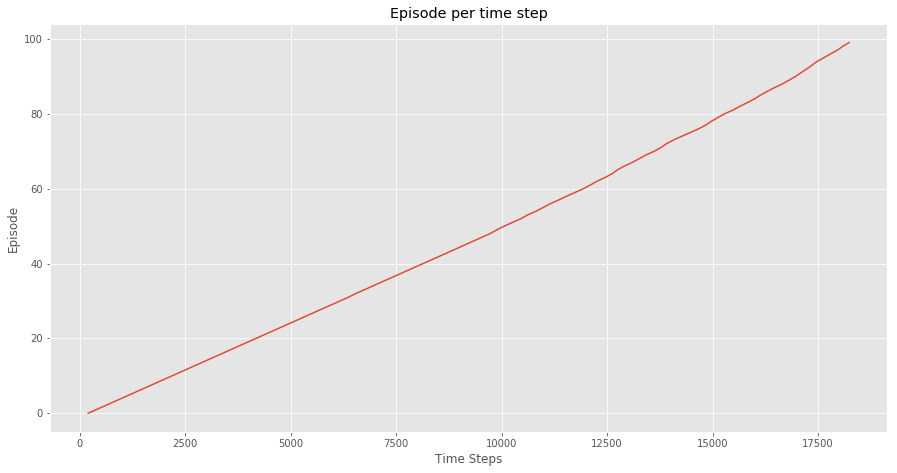

(<matplotlib.figure.Figure at 0x1c1a36d8>,
 <matplotlib.figure.Figure at 0x1ec36da0>)

In [33]:
def plot_cost_to_go_mountain_car(env, estimator, niter, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(15,7.5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=0, vmax=160)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_zlim(0, 160)
    ax.set_facecolor("white")
    ax.set_title("Cost To Go Function (iter:{})".format(niter))
    fig.colorbar(surf)
    plt.show()
    
def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(15,7.5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(15,7.5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(15,7.5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3


plot_cost_to_go_mountain_car(env, estimator, 100)
plot_episode_stats(result)